In [1]:
from ROOT import TH1F, TCanvas, gStyle, TLegend, TGraph
from sklearn.externals import joblib
from array import array
import pickle
from scipy.stats import ks_2samp
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LocallyConnected1D
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from keras.models import load_model
from nndrone.converters import BasicConverter
from nndrone.models import BaseModel
import os.path

trainFraction = 0.5

# load data
print ('Loading signal data file...')
sig_data = joblib.load('../../data/signal_data.p')
print ('Loading background data file...')
bkg_data = joblib.load('../../data/background_data.p')
#
cutIndex = int(trainFraction * len(sig_data))
#
sigTrain = sig_data[: cutIndex]
sigTest = sig_data[cutIndex:]
#
bgTrain = bkg_data[: cutIndex]
bgTest = bkg_data[cutIndex:]

# Load classifier and scaler
scaler = joblib.load('scaler_Bexample.pkl')
classifier = load_model('classifier_Bexample.h5')

# transform the training sameple
sigTrain = scaler.transform(sigTrain)
# do the same to the test data
sigTest = scaler.transform(sigTest)
# do the same to the test data
bgTrain = scaler.transform(bgTrain)
# do the same to the test data
bgTest = scaler.transform(bgTest)

train = np.append(sigTrain, bgTrain, axis=0)
target = [1] * len(sigTrain) + [0] * len(bgTrain)
test = np.append(sigTest, bgTest, axis=0)
target_test = [1] * len(sigTest) + [0] * len(bgTest)
#train = np.expand_dims(train.reshape(1, -1), axis=2)
#test = np.expand_dims(test.reshape(1, -1), axis=2)

Using TensorFlow backend.


Loading signal data file...
Loading background data file...


In [2]:
# initialize a list to store the loss value for each epoch
lossHistory = []

# Approx. control
alpha = 0.05
batchSize = 1
num_epochs = 300
threshold = 0.02

# layerSizes = [300, 1]
layerSizes = [5, 1]

converter = BasicConverter(num_epochs=num_epochs, batch_size=batchSize, learning_rate=alpha, threshold=threshold)

datasize = len(train)

# convert features and outputs to np array
train = np.array(train)

# shuffle signal and background
s = np.arange(train.shape[0])
np.random.shuffle(s)
train = train[s]

# Initialise model
model = BaseModel(len(train[0]), 1)
modelloc = 'approx_B_temp.pkl'
histloc = 'approx_B_temp_history.pkl'

if os.path.exists(modelloc):
    print ("Model found, loading")
    model.load_model(modelloc)
    [losses, diffs, updates] = joblib.load(histloc)
else:
    if len(layerSizes) == 1:
        model.add_layer(1)
    else:
        for l in layerSizes:
            model.add_layer(l)

    model.print_layers()

    print("Starting stochastic conversion...")
    converter.convert_model(model, classifier, train)
    losses = converter.losses()
    diffs = converter.diffs()
    updates = converter.updates()

    model.save_model(modelloc)

    f_train = open(histloc, 'wb')
    training_data = [losses, diffs, updates]
    pickle.dump(training_data, f_train)
    f_train.close()

BaseModel: Adding layer...
BaseModel: Adding weights matrix: (5,6)
BaseModel: Adding bias vector: (5,1)
BaseModel: Adding layer...
BaseModel: Adding weights matrix: (1,5)
BaseModel: Adding bias vector: (1,1)
Layer 1
Weights matrix shape: (5,6)
Bias vector shape (5,1)
Layer 2
Weights matrix shape: (1,5)
Bias vector shape (1,1)
Starting stochastic conversion...
Epoch: 0, loss 0.1107852921917279, diff 0.00000, last updated loss 1000.00000
Epoch: 1, loss 0.027059986944951674, diff 3.09406, last updated loss 1000.00000
Epoch: 2, loss 0.017880999414483567, diff 0.51334, last updated loss 1000.00000
Epoch: 3, loss 0.014846109303444143, diff 0.20442, last updated loss 1000.00000
Epoch: 4, loss 0.013322504657982822, diff 0.11436, last updated loss 1000.00000
Epoch: 5, loss 0.012420200131011002, diff 0.07265, last updated loss 1000.00000
Epoch: 6, loss 0.011830508074108502, diff 0.04985, last updated loss 1000.00000
Epoch: 7, loss 0.011418747104416562, diff 0.03606, last updated loss 1000.00000


In [3]:
# Add original decisions and drone decisions to dataframes
from copy import deepcopy
import time
def addProbs(df, cl, drone):
    df_ret = deepcopy(df)
    df_ret['prob_orig']= df.apply(lambda x: float(cl.predict_proba(np.expand_dims(x.reshape(1, -1), axis=2))[0]), axis=1)
    df_ret['prob_drone']= df.apply(lambda x: float(drone.evaluate_total(x, debug=False)), axis=1)
    return df_ret
def addProbs_l(l, cl, drone):
    print ("Adding %s probs" % len(l))
    p_orig = []
    p_drone = []
    start = time.clock()
    for x in l:
        p_orig.append(cl.predict_proba(np.expand_dims(x.reshape(1, -1), axis=2))[0].tolist()[0])
    diff = time.clock()-start
    print ("Original: Took %s seconds to evaluate %s calls: %.8f s/call" %(diff, len(l), diff/float(len(l))))
    start = time.clock()
    for x in l:
        p_drone.append(drone.evaluate_total(np.expand_dims(x.reshape(1, -1), axis=2), debug=False).tolist()[0][0])
    diff = time.clock()-start
    print ("Drone: Took %s seconds to evaluate %s calls: %.8f s/call" %(diff, len(l), diff/float(len(l))))
    return p_orig, p_drone

In [4]:
def scanPoint(cutVal, sig, bkg, pname):
    totSig = len(sig)
    totBKG = len(bkg)
    sig_pass = len(sig.loc[sig[pname] > cutVal])
    bkg_rej = len(bkg.loc[bkg[pname] < cutVal])
    bkg_pass = len(bkg.loc[bkg[pname] > cutVal])
    eff_sig = float(sig_pass)/float(totSig)
    rej_bkg = float(bkg_rej)/float(totBKG)
    return eff_sig, rej_bkg, sig_pass, bkg_pass
def scanPoint_l(cutVal, sig, bkg):
    totSig = len(sig)
    totBKG = len(bkg)
    sig_pass = len([s for s in sig if s > cutVal])
    bkg_rej = len([b for b in bkg if b < cutVal])
    bkg_pass = len([b for b in bkg if b > cutVal])
    eff_sig = float(sig_pass)/float(totSig)
    rej_bkg = float(bkg_rej)/float(totBKG)
    return eff_sig, rej_bkg, sig_pass, bkg_pass
def prepPlot(_ax, xtitle, ytitle):
    _ax.grid(False)
    _ax.set_xlabel(xtitle)
    _ax.set_ylabel(ytitle)
    _ax.set_title("")

Adding 5000 probs
Original: Took 2.232748000000015 seconds to evaluate 5000 calls: 0.00044655 s/call
Drone: Took 0.2266779999999926 seconds to evaluate 5000 calls: 0.00004534 s/call
Adding 5000 probs
Original: Took 2.083099999999945 seconds to evaluate 5000 calls: 0.00041662 s/call
Drone: Took 0.21591300000000047 seconds to evaluate 5000 calls: 0.00004318 s/call


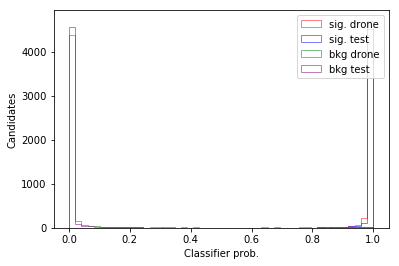

In [5]:
# Make outputs
sig_tst_o, sig_tst_d = addProbs_l(sigTest, classifier, model)
bkg_tst_o, bkg_tst_d = addProbs_l(bgTest, classifier, model)

bins_pr = np.linspace(0, 1, 50)
fig, ax1 = plt.subplots()
h_sig_drone = plt.hist(np.array(sig_tst_d), fill=False, edgecolor = 'red', bins = bins_pr, alpha=0.5, label="sig. drone", histtype='step')
h_sig_test = plt.hist(np.array(sig_tst_o), fill=False, edgecolor = 'blue', bins = bins_pr, alpha=0.5, label="sig. test", histtype='step')
h_bkg_drone = plt.hist(np.array(bkg_tst_d), edgecolor = 'green', fill=False, bins = bins_pr, alpha=0.5, label="bkg drone", histtype='step')
h_bkg_test = plt.hist(np.array(bkg_tst_o), fill=False, edgecolor = 'purple', bins = bins_pr, alpha=0.5, label="bkg test", histtype='step')
prepPlot(ax1, "Classifier prob.", "Candidates")
plt.legend()
plt.savefig('figs/output_comp_drone.png')
plt.show()

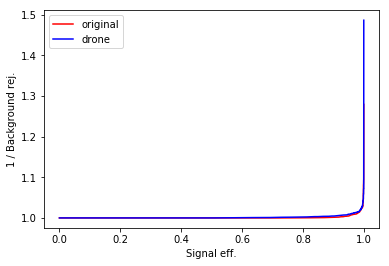

In [6]:
# Plot ROC comparison & FoM optimisation
eff_sig_drone = []
eff_sig_test = []
rej_bkg_drone = []
rej_bkg_test = []
#
scanpoints = np.linspace(0.0, 0.001, 1000)
scanpoints += np.linspace(0.001, 1.0, 1000)
for s in scanpoints:
    es, rb, nSig, nBKG = scanPoint_l(s, sig_tst_o, bkg_tst_o)
    es_dr, rb_dr, nSig_dr, nBKG_dr = scanPoint_l(s, sig_tst_d, bkg_tst_d)
    eff_sig_test.append(es)
    rej_bkg_test.append(1/rb)
    eff_sig_drone.append(es_dr)
    rej_bkg_drone.append(1/rb_dr)

fig, axes = plt.subplots()
plt1 = axes.plot(eff_sig_test, rej_bkg_test, 'r-', label = 'original')
plt2 = axes.plot(eff_sig_drone, rej_bkg_drone, 'b-', label= 'drone')
plt.legend()
prepPlot(axes, "Signal eff.", "1 / Background rej.")
plt.savefig('figs/roc.pdf')
plt.show()

Number of model additions: 10


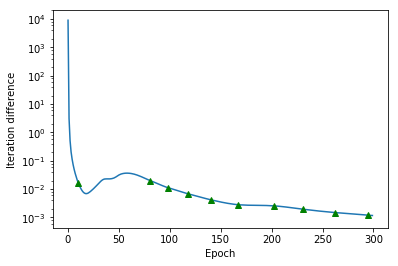

In [7]:
# Plot difference history
training = training_data
count = [n for n in range(len(training[0]))]
fig = plt.figure()
plt.plot(count, training[1], '-')
# Add markers where an update occurs
markers_x = [c for c, a in zip(count, training[2]) if a == 1]
markers_y = [d for d, a in zip(training[1], training[2]) if a == 1]
print('Number of model additions: %s' % len(markers_x))
plt.plot(markers_x, markers_y, 'g^')
fig.suptitle("")
plt.xlabel("Epoch")
plt.ylabel("Iteration difference")
plt.yscale('log')
plt.savefig("figs/diff_history.pdf")
plt.show()
plt.clf()

In [8]:
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 5, 90)             1350      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2730      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 4,111
Trainable params: 4,111
Non-trainable params: 0
_________________________________________________________________
